In [1]:
import sys
import os
import random
import torch.cuda
import torch.distributed
import torch.multiprocessing

from retinanet import infer, train, utils
from retinanet.model import Model
from retinanet import backbones
from retinanet._C import Engine

In [2]:
def load_model(config, verbose=False):
    if config.command != 'train' and not os.path.isfile(config.model):
        raise RuntimeError('Model file {} does not exist!'.format(config.model))

    model = None
    state = {}
    _, ext = os.path.splitext(config.model)

    if config.command == 'train' and (not os.path.exists(config.model) or config.override):
        if verbose: print('Initializing model...')
        model = Model(config.backbone, config.classes)
        model.initialize(config.fine_tune)
        if verbose: print(model)

    elif ext == '.pth' or ext == '.torch':
        if verbose: print('Loading model from {}...'.format(os.path.basename(config.model)))
        model, state = Model.load(config.model)
        if verbose: print(model)

    elif config.command == 'infer' and ext in ['.engine', '.plan']:
        model = None
    
    else:
        raise RuntimeError('Invalid model format "{}"!'.format(config.ext))

    state['path'] = config.model
    return model, state

def worker(rank, config, world, model, state):
    'Per-device distributed worker'

    if torch.cuda.is_available():
        os.environ.update({
            'MASTER_PORT': config.master.split(':')[-1],
            'MASTER_ADDR': ':'.join(config.master.split(':')[:-1]),
            'WORLD_SIZE':  str(world),
            'RANK':        str(rank),
            'CUDA_DEVICE': str(rank)
        })

        torch.cuda.set_device(rank)
        if rank > 0:
            torch.distributed.init_process_group(backend='nccl', init_method='env://')

        if config.batch % world != 0:
            raise RuntimeError('Batch size should be a multiple of the number of GPUs')

    if config.command == 'train':
        train.train(model, state, config.images, config.annotations,
            config.val_images or config.images, config.val_annotations, config.resize, config.max_size, config.jitter, 
            config.batch, int(config.iters * config.schedule), config.val_iters, not config.full_precision, config.lr, 
            config.warmup, [int(m * config.schedule) for m in config.milestones], config.gamma, 
            is_master=(rank == 0), world=world, use_dali=config.with_dali,
            metrics_url=config.post_metrics, logdir=config.logdir, verbose=(rank == 0))

    elif config.command == 'infer':
        if model is None:
            if rank == 0: print('Loading CUDA engine from {}...'.format(os.path.basename(config.model)))
            model = Engine.load(config.model)

        infer.infer(model, config.images, config.output, config.resize, config.max_size, config.batch,
            annotations=config.annotations, mixed_precision=not config.full_precision,
            is_master=(rank == 0), world=world, use_dali=config.with_dali, verbose=(rank == 0))

    elif config.command == 'export':
        onnx_only = config.export.split('.')[-1] == 'onnx'
        input_size = config.size * 2 if len(config.size) == 1 else config.size

        calibration_files = []
        if config.int8:
            # Get list of images to use for calibration
            if os.path.isdir(config.calibration_images):
                import glob
                file_extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']
                for ex in file_extensions:
                    calibration_files += glob.glob("{}/*{}".format(config.calibration_images, ex), recursive=True)
                # Only need enough images for specified num of calibration batches
                if len(calibration_files) >= config.calibration_batches * config.batch:
                    calibration_files = calibration_files[:(config.calibration_batches * config.batch)]
                else:
                    print('Only found enough images for {} batches. Continuing anyway...'.format(len(calibration_files) // config.batch))

                random.shuffle(calibration_files)

        precision = "FP32"
        if config.int8:
            precision = "INT8"
        elif not config.full_precision:
            precision = "FP16"

        exported = model.export(input_size, config.batch, precision, calibration_files, config.calibration_table, config.verbose, onnx_only=onnx_only, opset=config.opset)
        if onnx_only:
            with open(config.export, 'wb') as out:
                out.write(exported)
        else:
            exported.save(config.export)

def main(config=None):
    'Entry point for the retinanet command'

    model, state = load_model(config, verbose=True)
    if model: model.share_memory()

    world = torch.cuda.device_count()
    if config.command == 'export' or world <= 1:
        worker(0, config, 1, model, state)
    else:
        torch.multiprocessing.spawn(worker, args=(config, world, model, state), nprocs=world)

In [3]:
class RetinanetConfig(object):
    # Adress and port of the master worker
    master = '127.0.0.1:29500'

    # run mode: train, infer, export
    command = 'train'

    devcount = max(1, torch.cuda.device_count())

    ### Train, Inference, and Export variables
    # path to output model or checkpoint to resume from
    model = 'models/retinanet_rn50fpn.pth'
    # batch size, default for TensorRT engine is 2
    batch = 2 * devcount
    # train in full precision
    full_precision = False
    
    ### Train and Inference variables
    # path to COCO style annotations
    annotations = 'labels/annotaions.json'
    # path to images
    images = 'images/'
    # save detections to specified JSON file
    output = 'detections.json'
    # resize to given size
    resize = 800
    # maximum resizing size
    max_size = 1333
    # use dali for data loading
    with_dali = False
    
    ### Train only variables
    # path to COCO style validation annotations
    val_annotations = 'labels/val-annotations.json'
    # path to validation images
    val_images = 'images/'
    # backbone model (or list of)
    backbone = ['ResNet50FPN']
    # number of classes
    classes = 80
    # jitter size within range: [min, max]
    jitter = [640, 1024]
    # number of iterations to train for
    iters = 90000
    # list of iteration indices where learning rate decays
    milestones = [60000, 80000]
    # scale schedule (affecting iters and milestones)
    schedule = 1
    # learning rate
    lr = 0.01
    # numer of warmup iterations
    warmup= 1000
    # multiplicative factor of learning rate decay
    gamma = 0.1
    # override model
    override = False
    # post metrics to specified url
    post_metrics = ''
    # fine tune a pretrained model at provided path
    fine_tune = ''
    # directory where to write logs
    logdir = 'logs/'
    # number of iterations between each validation
    val_iters = 8000

    # Export only variables
    # path to exported output
    export = 'models/export.pth'
    # input size (square) or sizes (h w) to use when generating TensorRT engine
    size = [1280]
    # calibrate model and export in int8 precision
    int8 = False
    # ONNX opset version (int)
    opset = 10
    # number of batches to use for int8 calibration
    calibration_batches = 10
    # path to calibration images to use for int8 calibration
    calibration_images = ""
    # path of existing calibration table to load from, or name of new calibration table
    calibration_table = ""
    # enable verbose logging
    verbose = False

In [5]:
class ResNetConfig(RetinanetConfig):
    command = 'train'
    fine_tune = '../models/retinanet_rn34fpn.pth'
    model = '../models/retinanet_rn34fpn-512_2048.pth'
    annotations = '../labels/defect_labels_coco_120px-train.json'
    images = '../images/'
    val_annotations = '../labels/defect_labels_coco_120px-test.json'
    val_images = '../images/'
    logdir = '../logs/'
    backbone = ['ResNet34FPN']
    classes = 1
    iters = 10000
    val_iters = 1000
    lr = 2e-5
    milestones = [3000, 6000, 9000]
    warmup= 100
    jitter = [480, 512]
    resize = 512
    max_size = 2048

In [6]:
config = ResNetConfig()
main(config)

Initializing model...
Fine-tuning weights from retinanet_rn34fpn.pth...
     model: RetinaNet
  backbone: ResNet34FPN
   classes: 1, anchors: 9
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : 128.0
Preparing dataset...
    loader: pytorch
    resize: [480, 512], max: 2048
    device: 1 gpu
    batch: 2, precision: mixed
Training model for 10000 iterations.

[ 4141/10000] focal loss: 0.310, box loss: 0.107, 0.429s/2-batch (fw: 0.148s, bw: 0.278s), 4.7 im/s, lr: 2e-06
[ 4282/10000] focal loss: 0.215, box loss: 0.071, 0.427s/2-batch (fw: 0.149s, bw: 0.279s), 4.7 im/s, lr: 2e-06
[ 4423/10000] focal loss: 0.245, box loss: 0.082, 0.428s/2-batch (fw: 0.147s, bw: 0.278s), 4.7 im/s, lr: 2e-06
[ 4564/10000] focal loss: 0.277, box loss: 0.098, 0.428s/2-batch (fw: 0.148s, bw: 0.277s), 4.7 im/s, lr: 2e-06
[ 4705/10000] focal loss: 0.196, box loss: 0.064, 0.426s/2-batch (fw: 0.148s, bw: 0.278s), 4.7 im/s, lr: 2e-06
[ 4845/10000] focal loss: 0.222, box loss: 0.075, 0.430s/2-batch (fw: 0.150s, bw: 0.278s), 4.7 im/s, lr: 2e-06
[ 4986/10000] focal loss: 0.250, box loss: 0.086, 0.428s/2-batch (fw: 0.148s, bw: 0.277s), 4.7 im/s, lr: 2e-06
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.19149
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.31641
 Average Precision  (AP) @[ IoU=0.75      | area=   all | m

[ 9123/10000] focal loss: 0.246, box loss: 0.085, 0.485s/2-batch (fw: 0.148s, bw: 0.277s), 4.1 im/s, lr: 2e-08
[ 9263/10000] focal loss: 0.305, box loss: 0.107, 0.430s/2-batch (fw: 0.149s, bw: 0.278s), 4.7 im/s, lr: 2e-08
[ 9404/10000] focal loss: 0.208, box loss: 0.070, 0.427s/2-batch (fw: 0.149s, bw: 0.278s), 4.7 im/s, lr: 2e-08
[ 9544/10000] focal loss: 0.240, box loss: 0.081, 0.429s/2-batch (fw: 0.149s, bw: 0.277s), 4.7 im/s, lr: 2e-08
[ 9684/10000] focal loss: 0.269, box loss: 0.097, 0.429s/2-batch (fw: 0.149s, bw: 0.277s), 4.7 im/s, lr: 2e-08
[ 9825/10000] focal loss: 0.189, box loss: 0.061, 0.426s/2-batch (fw: 0.148s, bw: 0.278s), 4.7 im/s, lr: 2e-08
[ 9966/10000] focal loss: 0.217, box loss: 0.073, 0.428s/2-batch (fw: 0.148s, bw: 0.277s), 4.7 im/s, lr: 2e-08
[10000/10000] focal loss: 0.178, box loss: 0.059, 0.427s/2-batch (fw: 0.148s, bw: 0.278s), 4.7 im/s, lr: 2e-08
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.19365
 Average Precision  (AP) @[ Io

In [4]:
class ResNetConfig_Infer(RetinanetConfig):
    command = 'infer'
    model = '../models/retinanet_rn34fpn-finetune.pth'
    images = '../test_images'
    annotations = ''
    output = '../predictions/detections.json'

In [5]:
main(ResNetConfig_Infer)

Loading model from retinanet_rn34fpn-finetune.pth...
     model: RetinaNet
  backbone: ResNet34FPN
   classes: 1, anchors: 9
Preparing dataset...
    loader: pytorch
    resize: 800, max: 1333
   backend: pytorch
    device: 1 gpu
     batch: 2, precision: mixed
Running inference...
[1/1] 1.255s/2-batch (fw: 1.121s), 1.6 im/s
Gathering results...
Writing ../predictions/detections.json...


In [6]:
import cv2
import json
import matplotlib.pyplot as plt

In [8]:
with open("../predictions/detections.json", "r") as read_file:
    preds = json.load(read_file)

(1100, 4096, 3)


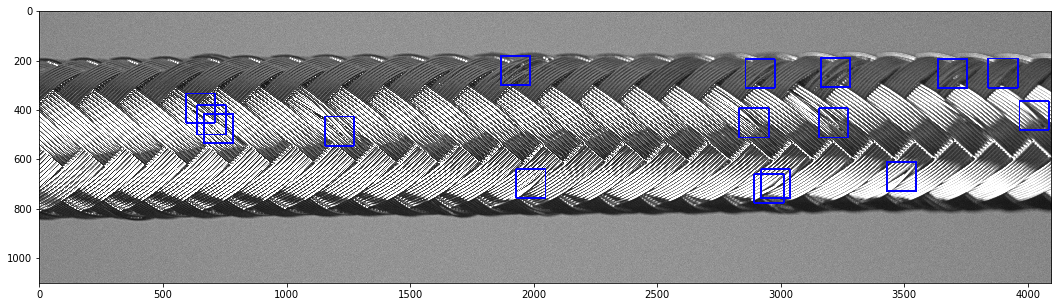

In [17]:
img = cv2.imread("../test_images/Image00030-Copy1.BMP")
print(img.shape)
for annot in preds['annotations']:
    if annot['score'] < 0.3:
        break
        
    tl = (int(annot['bbox'][0]), int(annot['bbox'][1]))
    br = (int(annot['bbox'][0] + annot['bbox'][2]), int(annot['bbox'][1] + annot['bbox'][3]))
#     tl = (int(annot['bbox'][0] - annot['bbox'][2] / 2), int(annot['bbox'][1] - annot['bbox'][3] / 2))
#     br = (int(annot['bbox'][0] + annot['bbox'][2] / 2), int(annot['bbox'][1] + annot['bbox'][3] / 2))
    cv2.rectangle(img, tl, br, (0, 0, 255), 6)
    
plt.figure(figsize=(20,5))
plt.imshow(img)
plt.show()